In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from xgboost import XGBRegressor
from math import sqrt
from sklearn.feature_selection import SequentialFeatureSelector
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV

operating_system = 'mac'

if operating_system == 'win':
    os.chdir('C:/Users/fabau/OneDrive/Documents/GitHub/master-project-cleaned/')
elif operating_system == 'curnagl':
    os.chdir('/work/FAC/FGSE/IDyST/tbeucler/default/fabien/repos/cleaner_version/')
else:
    os.chdir('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/')

# Add the path to the custom library
custom_library_path = os.path.abspath('util/processing/')
sys.path.append(custom_library_path)
custom_library_path = os.path.abspath('util/gev/')
sys.path.append(custom_library_path)
custom_library_path = os.path.abspath('util/feature_selection/')
sys.path.append(custom_library_path)

import extraction_squares, pre_processing_data, data_processing, selection_vars

'''if operating_system == 'curnagl':
    name_of_variable= pd.read_csv('/work/FAC/FGSE/IDyST/tbeucler/default/fabien/repos/curnagl/DATASETS/variable_list_80_mean.csv')
    path_data = '/work/FAC/FGSE/IDyST/tbeucler/default/fabien/repos/curnagl/DATASETS'
else:'''
name_of_variable_20 = pd.read_csv('pre_processing/feature_selection/fs_corr_timeseries/corr_inst_max_20.csv')['Unnamed: 0']#('data/variable_list_levels.csv')
name_of_variable_30 = pd.read_csv('pre_processing/feature_selection/fs_corr_timeseries/corr_inst_max_30.csv')['Unnamed: 0']#('data/variable_list_levels.csv')
name_of_variable_40 = pd.read_csv('pre_processing/feature_selection/fs_corr_timeseries/corr_inst_max_40.csv')['Unnamed: 0']#('data/variable_list_levels.csv')

path_data = 'data'

storm_dates = pd.read_csv('pre_processing/tracks/storm_dates.csv')
#path_tracks_1h_non_EU = 'pre_processing/tracks/ALL_TRACKS/tracks_1h_non_EU'
#dataset = 'datasets_1h'
#dataset_non_EU = 'datasets_1h_non_EU'
levels = pd.read_csv('data/levels.csv')

In [64]:
def prepare_training_data(transposed_data, storm_index_training, updated_columns):
    """
    Prepare training data by filtering and concatenating rows based on storm indices.

    Parameters:
        transposed_data (pd.DataFrame): The input DataFrame containing data to filter.
        storm_index_training (list): List of storm indices to filter the data by.
        updated_columns (list): List of column names to update the resulting DataFrame.

    Returns:
        pd.DataFrame: The processed training data with specified columns and without 'storm_number'.
    """
    X_train = []
    
    for storm_index in storm_index_training:
        temp = transposed_data[transposed_data['storm_number'] == storm_index]
        X_train.append(temp)
    
    # Concatenate the filtered data
    X_train = np.concatenate(X_train, axis=0)
    
    # Convert to DataFrame
    X_train = pd.DataFrame(X_train, columns=updated_columns)
    
    # Drop the 'storm_number' column
    try:
        X_train = X_train.drop(columns=['storm_number'])
    except KeyError:
        X_train = X_train.drop(columns=['storm_number_PCA_1'])
        print('No storm_number column to drop, which is not fine')
    
    return X_train

def process_y_data(y_all_cdf, storm_index_training):
    """
    Process the y_all_cdf DataFrame to filter, sort, and convert it into a NumPy array 
    for training purposes.

    Parameters:
        y_all_cdf (pd.DataFrame): DataFrame containing storm-related data, including 'storm_name' and 'storm_number'.
        storm_index_training (list or iterable): List of storm indices to include in the training data.

    Returns:
        np.ndarray: Processed NumPy array of the training data without 'storm_name' and 'storm_number'.
    """
    # Drop 'storm_name' column
    try:
        y_all_cdf = y_all_cdf.drop(columns=['storm_name'])
    except KeyError:
        print('No storm_name column to drop')
    
    # Filter rows where 'storm_number' is in storm_index_training
    y_train = y_all_cdf[y_all_cdf['storm_number'].isin(storm_index_training)]
    
    # Sort by 'storm_number' and reset index
    y_train = y_train.sort_values(by=['storm_number']).reset_index(drop=True)
    
    # Drop 'storm_number' column
    y_train = y_train.drop(columns=['storm_number'])
    
    # Convert to NumPy array
    y_train_np = y_train.to_numpy()
    
    return y_train_np
    
def evaluate_models(y_true, predictions_dict):
    """
    Evaluate RMSE, MAE, and transformed RMSE for multiple models.

    Parameters:
    - y_true (array-like): Ground truth (true) target values.
    - predictions_dict (dict): Dictionary where keys are model names and values are predictions.

    Returns:
    - results (dict): Dictionary containing RMSE, MAE, and transformed RMSE metrics for each model.
    """
    results = {}
    y_true_real = 1 - np.exp(-y_true)  # Transform y_true to real units

    for model_name, predictions in predictions_dict.items():
        # Calculate RMSE and MAE
        rmse = root_mean_squared_error(y_true, predictions)
        mae = mean_absolute_error(y_true, predictions)

        # Transform predictions to real units
        predictions_real = 1 - np.exp(-predictions)

        # Calculate transformed RMSE
        rmse_real = root_mean_squared_error(y_true_real, predictions_real)

        # Calculate return RMSE
        return_rmse = round((1 / (1 - rmse_real)) / 2, 2)

        # Store results for the current model
        results[model_name] = {
            "RMSE": rmse,
            "MAE": mae,
            "Transformed RMSE": rmse_real,
            "Return RMSE": return_rmse
        }
    
    return results

In [5]:
# import the all_loadings data
all_loadings = pd.read_csv('pre_processing/nestedMLR/all_loadings.csv')

# Extract variable names and storm data
variables = all_loadings['variable']  # First column
storm_data = all_loadings.iloc[:, 1:]  # All columns from the second onward

# Transpose storm data and set variable names as columns
transposed_data = storm_data.T
transposed_data.columns = variables

# Optionally reset index to name storms
transposed_data.index.name = 'storm_number'
transposed_data.reset_index(inplace=True)

# extract the storm number
storm_numbers = transposed_data['storm_number'].copy()

# Extract variables most correlated with the target and leaving the storm number
columns_to_select_20 = [col for col in name_of_variable_20.tolist() if col in transposed_data.columns]
transposed_data_20 = transposed_data[columns_to_select_20]
columns_to_select_30 = [col for col in name_of_variable_30.tolist() if col in transposed_data.columns]
transposed_data_30 = transposed_data[columns_to_select_30]
columns_to_select_40 = [col for col in name_of_variable_40.tolist() if col in transposed_data.columns]
transposed_data_40 = transposed_data[columns_to_select_40]

# add the storm number to the transposed data
transposed_data_20['storm_number'] = storm_numbers
transposed_data_30['storm_number'] = storm_numbers
transposed_data_40['storm_number'] = storm_numbers

'''original_data = transposed_data.copy()
original_columns = transposed_data.columns
original_data['storm_number'] = original_data['storm_number'].astype(int)'''

# Add PCA numbers to each variable to differentiate modes

# Count how many times each variable appears in the column names
variable_counts_20 = transposed_data_20.columns.value_counts()
# Create a mapping with PCA numbers appended to each variable
updated_columns_20 = []
pca_tracker_20 = {}
# for 20 variables
for var in transposed_data_20.columns:
    if var not in pca_tracker_20:
        pca_tracker_20[var] = 1
    else:
        pca_tracker_20[var] += 1
    # Append PCA number to the variable name
    updated_columns_20.append(f"{var}_PCA_{pca_tracker_20[var]}")
# Update the column names
transposed_data_20.columns = updated_columns_20
# rename the first column to storm_number
transposed_data_20 = transposed_data_20.rename(columns={'storm_number_PCA_1': 'storm_number'})
transposed_data_20['storm_number'] = transposed_data_20['storm_number'].astype(int)

# for 30 variables
updated_columns_30 = []
pca_tracker_30 = {}
for var in transposed_data_30.columns:
    if var not in pca_tracker_30:
        pca_tracker_30[var] = 1
    else:
        pca_tracker_30[var] += 1
    # Append PCA number to the variable name
    updated_columns_30.append(f"{var}_PCA_{pca_tracker_30[var]}")
# Update the column names
transposed_data_30.columns = updated_columns_30
# rename the first column to storm_number
transposed_data_30 = transposed_data_30.rename(columns={'storm_number_PCA_1': 'storm_number'})
transposed_data_30['storm_number'] = transposed_data_30['storm_number'].astype(int)

# for 40 variables
updated_columns_40 = []
pca_tracker_40 = {}
for var in transposed_data_40.columns:
    if var not in pca_tracker_40:
        pca_tracker_40[var] = 1
    else:
        pca_tracker_40[var] += 1
    # Append PCA number to the variable name
    updated_columns_40.append(f"{var}_PCA_{pca_tracker_40[var]}")
# Update the column names
transposed_data_40.columns = updated_columns_40
# rename the first column to storm_number
transposed_data_40 = transposed_data_40.rename(columns={'storm_number_PCA_1': 'storm_number'})
transposed_data_40['storm_number'] = transposed_data_40['storm_number'].astype(int)

# Extract storm indices
storm_indices = transposed_data_20['storm_number'].to_numpy()
# separate the data in training and testing
storm_index_training, storm_index_test, storm_index_validation = extraction_squares.split_storm_numbers(storm_indices, 0.12, 42, 'number')

# order the index of the storms

storm_index_training.sort()
storm_index_test.sort()
storm_index_validation.sort()

# add +1 to the storm index to match the storm index in the storm_dates dataframe (it's actually storm index for this set, so +1 is needed)
#storm_index_training = [x+1 for x in storm_index_training]
#storm_index_test = [x+1 for x in storm_index_test]
#storm_index_validation = [x+1 for x in storm_index_validation]

print("Storm Training:", storm_index_training)
print("Storm Test:", storm_index_test)
print("Storm Valid:", storm_index_validation) 

# remove the variable convective_rain_rate and vertical_velocity
#columns_to_drop = transposed_data.columns[transposed_data.columns.str.startswith(('convective_rain_rate', 'vertical_velocity'))]
#transposed_data = transposed_data.drop(columns=columns_to_drop)

# Update the column names
#updated_columns = transposed_data.columns

X_train_pca_20 = prepare_training_data(transposed_data_20, storm_index_training, updated_columns_20)
X_test_pca_20 = prepare_training_data(transposed_data_20, storm_index_test, updated_columns_20)
X_validation_pca_20 = prepare_training_data(transposed_data_20, storm_index_validation, updated_columns_20)

X_train_pca_30 = prepare_training_data(transposed_data_30, storm_index_training, updated_columns_30)
X_test_pca_30 = prepare_training_data(transposed_data_30, storm_index_test, updated_columns_30)
X_validation_pca_30 = prepare_training_data(transposed_data_30, storm_index_validation, updated_columns_30)

X_train_pca_40 = prepare_training_data(transposed_data_40, storm_index_training, updated_columns_40)
X_test_pca_40 = prepare_training_data(transposed_data_40, storm_index_test, updated_columns_40)
X_validation_pca_40 = prepare_training_data(transposed_data_40, storm_index_validation, updated_columns_40)

# without the PCA in the names :

'''X_train_original = prepare_training_data(original_data, storm_index_training, original_columns)
X_validation_original = prepare_training_data(original_data, storm_index_validation, original_columns)
X_test_original = prepare_training_data(original_data, storm_index_test, original_columns)

X_train_original = X_train_original[columns_to_select]
X_validation_original = X_validation_original[columns_to_select]
X_test_original = X_test_original[columns_to_select]'''

# load the actual y values

y_all_cdf = pd.read_csv('data/climatology_dm_winter_per_cluster/GEV_CDF_max/log_cdf_max_combined.csv')

y_train_cdf = process_y_data(y_all_cdf, storm_index_training)
y_test_cdf = process_y_data(y_all_cdf, storm_index_test)
y_validation_cdf = process_y_data(y_all_cdf, storm_index_validation)

y_all_max = pd.read_csv('data/climatology_dm_winter_per_cluster/EVENT_max/max_event_combined.csv')

y_train_max = process_y_data(y_all_max, storm_index_training)
y_test_max = process_y_data(y_all_max, storm_index_test)
y_validation_max = process_y_data(y_all_max, storm_index_validation)

To keep 50 storms in the training set, storms 45 and 87 are removed from the test set.
Storm Training: [1, 2, 3, 5, 7, 8, 11, 12, 13, 16, 19, 26, 27, 31, 32, 34, 39, 43, 45, 46, 49, 50, 51, 53, 54, 56, 60, 61, 62, 63, 64, 65, 67, 68, 69, 71, 72, 73, 76, 77, 78, 79, 80, 81, 82, 85, 87, 89, 90, 95]
Storm Test: [6, 29, 38, 48, 66, 86, 93]
Storm Valid: [21, 33, 44, 47, 58, 83]
No storm_number column to drop, which is not fine
No storm_number column to drop, which is not fine
No storm_number column to drop, which is not fine
No storm_number column to drop, which is not fine
No storm_number column to drop, which is not fine
No storm_number column to drop, which is not fine
No storm_number column to drop, which is not fine
No storm_number column to drop, which is not fine
No storm_number column to drop, which is not fine


/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_12201/3845155811.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transposed_data_20['storm_number'] = storm_numbers.values
/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_12201/3845155811.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transposed_data_30['storm_number'] = storm_numbers
/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_12201/3845155811.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy

# Shape the data for multiple outputs

The shape should be like (storms, variables * steps)

In [8]:
X_train_np_20 = X_train_pca_20.to_numpy()
X_validation_np_20 = X_validation_pca_20.to_numpy()

X_train_np_30 = X_train_pca_30.to_numpy()
X_validation_np_30 = X_validation_pca_30.to_numpy()

X_train_np_40 = X_train_pca_40.to_numpy()
X_validation_np_40 = X_validation_pca_40.to_numpy()

# Initialize and train XGBoost with a multi-output wrapper
model_xgb_cdf_20 = (XGBRegressor(random_state=42, n_jobs=-1)) #MultiOutputRegressor
model_xgb_cdf_20.fit(X_train_np_20, y_train_cdf)

model_xgb_cdf_30 = (XGBRegressor(random_state=42, n_jobs=-1)) #MultiOutputRegressor
model_xgb_cdf_30.fit(X_train_np_30, y_train_cdf)

model_xgb_cdf_40 = (XGBRegressor(random_state=42, n_jobs=-1)) #MultiOutputRegressor
model_xgb_cdf_40.fit(X_train_np_40, y_train_cdf)

model_xgb_max_20 = (XGBRegressor(random_state=42, n_jobs=-1)) #MultiOutputRegressor
model_xgb_max_20.fit(X_train_np_20, y_train_max)

model_xgb_max_30 = (XGBRegressor(random_state=42, n_jobs=-1)) #MultiOutputRegressor
model_xgb_max_30.fit(X_train_np_30, y_train_max)

model_xgb_max_40 = (XGBRegressor(random_state=42, n_jobs=-1)) #MultiOutputRegressor
model_xgb_max_40.fit(X_train_np_40, y_train_max)

# Predictions
predictions_xgb_cdf_20 = model_xgb_cdf_20.predict(X_validation_np_20)
predictions_xgb_max_20 = model_xgb_max_20.predict(X_validation_np_20)

predictions_xgb_cdf_30 = model_xgb_cdf_30.predict(X_validation_np_30)
predictions_xgb_max_30 = model_xgb_max_30.predict(X_validation_np_30)

predictions_xgb_cdf_40 = model_xgb_cdf_40.predict(X_validation_np_40)
predictions_xgb_max_40 = model_xgb_max_40.predict(X_validation_np_40)


In [65]:
# Evaluate models
predictions_dict_cdf = {
    #"RandomForest": predictions_rf,
    "XGBoost_cdf_20": predictions_xgb_cdf_20,
    "XGBoost_cdf_30": predictions_xgb_cdf_30,
    "XGBoost_cdf_40": predictions_xgb_cdf_40,
    #"LightGBM": predictions_lgbm,
    #"GradientBoosting": predictions_gb
}
prediction_dict_max = {
    "XGBoost_max_20": predictions_xgb_max_20,
    "XGBoost_max_30": predictions_xgb_max_30,
    "XGBoost_max_40": predictions_xgb_max_40,
}

results_cdf = evaluate_models(y_validation_cdf, predictions_dict_cdf)
results_max = evaluate_models(y_validation_max, prediction_dict_max)

# Print results
for model_name, metrics in results_cdf.items():
    print(f"Model: {model_name}")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print()

for model_name, metrics in results_max.items():
    print(f"Model: {model_name}")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print()

Model: XGBoost_cdf_20
RMSE: 1.4746858079184977
MAE: 1.1508057535607916
Transformed RMSE: 0.2768229515188663
Return RMSE: 0.69

Model: XGBoost_cdf_30
RMSE: 1.339936933283176
MAE: 1.0185885697695138
Transformed RMSE: 0.267636121518658
Return RMSE: 0.68

Model: XGBoost_cdf_40
RMSE: 1.1832138356174717
MAE: 0.9447776332947754
Transformed RMSE: 0.24396292456138516
Return RMSE: 0.66

Model: XGBoost_max_20
RMSE: 6.123475384342268
MAE: 4.971760742067031
Transformed RMSE: 1.2950618712991784e-06
Return RMSE: 0.5

Model: XGBoost_max_30
RMSE: 5.742545884611103
MAE: 4.657823254719799
Transformed RMSE: 1.0912230246845791e-06
Return RMSE: 0.5

Model: XGBoost_max_40
RMSE: 5.598417002605498
MAE: 4.669421810328088
Transformed RMSE: 1.0893892587837068e-06
Return RMSE: 0.5



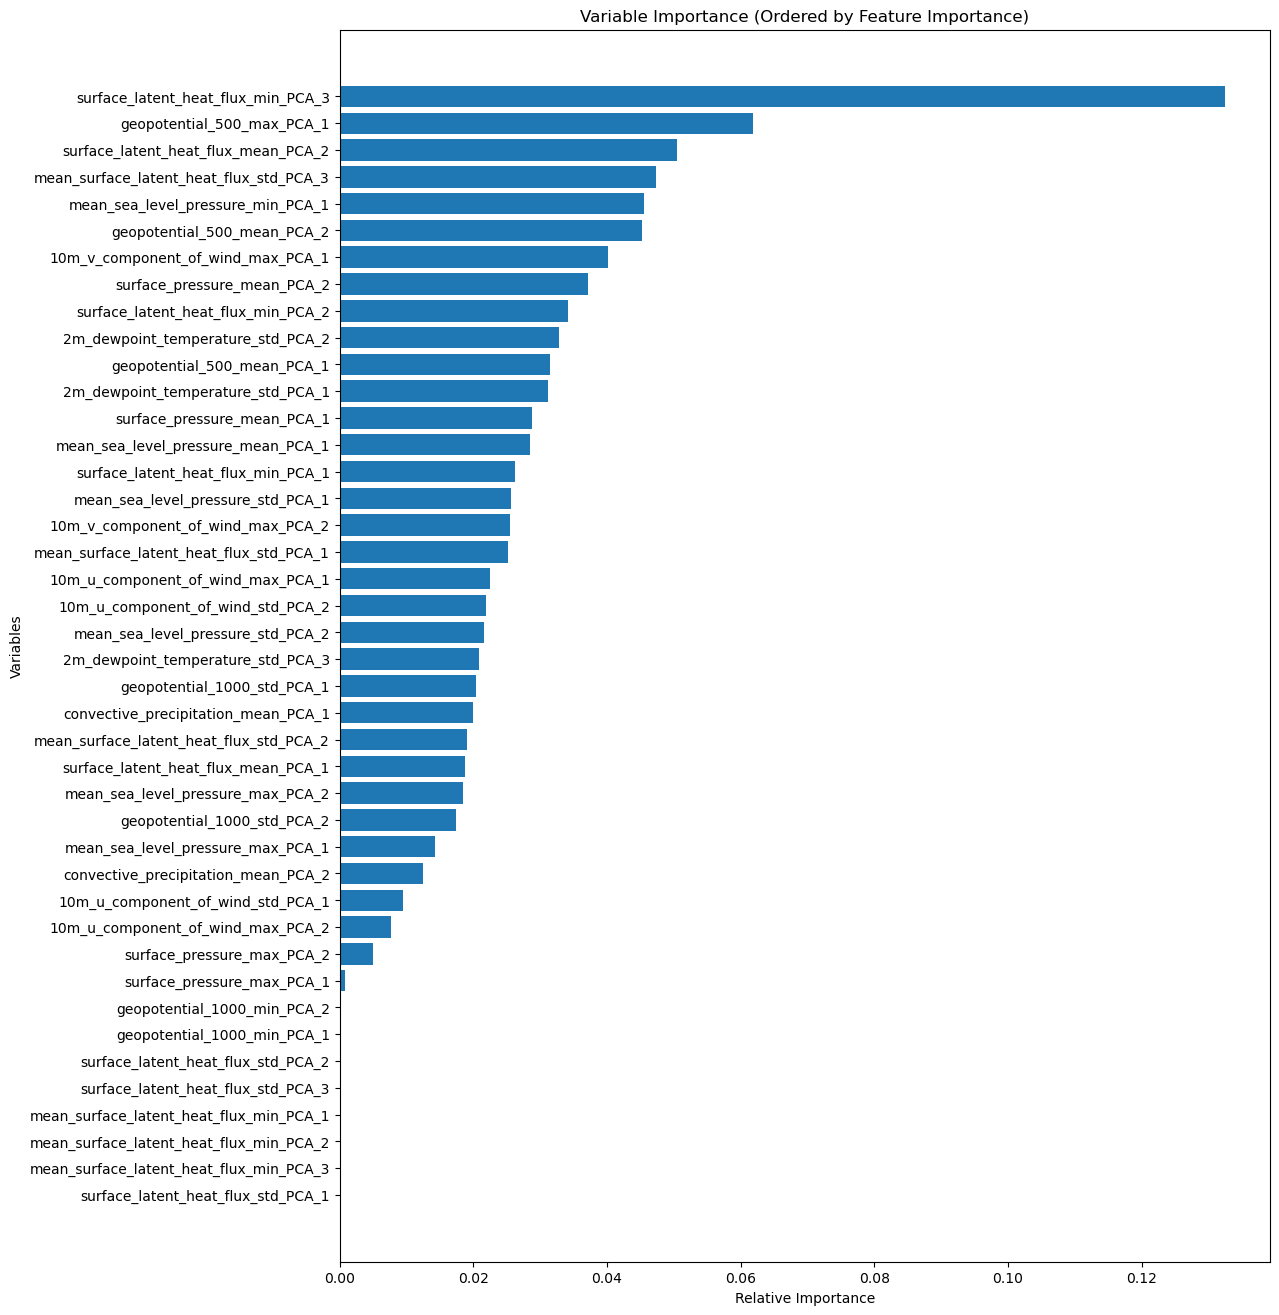

In [55]:
# see the feature importance of the xgboost
feature_importance_xgb = model_xgb_cdf.feature_importances_
variable_names_xgb = X_train_pca.columns  # Assuming it's a pandas Index or list

'''# Create a DataFrame to facilitate grouping
importance_df_xgb = pd.DataFrame({
    'variable': variable_names_xgb,
    'importance': feature_importance_xgb
})

# Extract base variable names (e.g., "2m_temperature" from "2m_temperature_t1")
# Adjust the regex if your variable naming convention differs
importance_df_xgb['base_variable'] = importance_df_xgb['variable'].str.extract(r'(^[a-zA-Z0-9_]+)_PCA_[0-9]+')
# Group by base variable name and sum the importance scores
grouped_importance_xgb = (
    importance_df_xgb.groupby('base_variable', as_index=False)
    .agg({'importance': 'sum'})
)

# Normalize importance scores
grouped_importance_xgb['importance'] = 100.0 * (grouped_importance_xgb['importance'] / grouped_importance_xgb['importance'].max())

# Sort by importance
grouped_importance_xgb = grouped_importance_xgb.sort_values('importance', ascending=False)'''

'''# Plot the combined feature importance
plt.figure(figsize=(12, 6))
plt.barh(variable_names_xgb, feature_importance_xgb, align='center')
plt.xlabel('Relative Importance')
plt.title('Variable Importance (Combined)')
plt.ylim(-1, 40)
plt.gca().invert_yaxis()  # Invert the y-axis to show the highest importance on top
plt.show()'''

# Sort variables by feature importance
sorted_indices = feature_importance_xgb.argsort()  # Get indices that sort the array
sorted_feature_importance = feature_importance_xgb[sorted_indices]  # Sorted importance values
sorted_variable_names = variable_names_xgb[sorted_indices]  # Sorted variable names

# Plot the sorted feature importance
plt.figure(figsize=(12, 16))
plt.barh(sorted_variable_names, sorted_feature_importance, align='center')
plt.xlabel('Relative Importance')
plt.ylabel('Variables')
plt.title('Variable Importance (Ordered by Feature Importance)')
#plt.gca().invert_yaxis()  # Invert the y-axis to show the highest importance on top
plt.show()

# use sequential selection for selecting the right features

In [11]:
'''# Initialize the sequential feature selector
sfs = SequentialFeatureSelector(
                                model_xgb_cdf,  # Use the same model as before
                                n_features_to_select=5,  # Select 5 features
                                direction='forward',  # Forward selection
                                n_jobs=-1  # Use all available cores
                                )   

# Fit the SFS model
sfs.fit(X_train_original, y_train_cdf)'''

print('Feature selection')
print('20 variables on CDF')
selected_vars_cdf_20 = selection_vars.feature_selection(X_train_pca_20, X_train_np_20, y_train_cdf, model_xgb_cdf_20)
print('')
print('30 variables on CDF')
selected_vars_cdf_30 = selection_vars.feature_selection(X_train_pca_30, X_train_np_30, y_train_cdf, model_xgb_cdf_30)
print('')
print('40 variables on CDF')
selected_vars_cdf_40 = selection_vars.feature_selection(X_train_pca_40, X_train_np_40, y_train_cdf, model_xgb_cdf_40)
print('')
print('20 variables on max')
selected_vars_max_20 = selection_vars.feature_selection(X_train_pca_20, X_train_np_20, y_train_max, model_xgb_max_20)
print('')
print('30 variables on max')
selected_vars_max_30 = selection_vars.feature_selection(X_train_pca_30, X_train_np_30, y_train_max, model_xgb_max_30)
print('')
print('40 variables on max')
selected_vars_max_40 = selection_vars.feature_selection(X_train_pca_40, X_train_np_40, y_train_max, model_xgb_max_40)

Feature selection
20 variables on CDF
y is already a numpy array
Selected features: Index(['mean_surface_latent_heat_flux_std_PCA_2',
       'mean_surface_latent_heat_flux_std_PCA_3', 'geopotential_500_max_PCA_1',
       'surface_pressure_max_PCA_2', 'geopotential_1000_std_PCA_2'],
      dtype='object')

30 variables on CDF
y is already a numpy array
Selected features: Index(['10m_u_component_of_wind_std_PCA_2', 'geopotential_500_max_PCA_1',
       'surface_pressure_max_PCA_2', '2m_temperature_std_PCA_1',
       'surface_pressure_min_PCA_4'],
      dtype='object')

40 variables on CDF
y is already a numpy array
Selected features: Index(['geopotential_500_max_PCA_1', 'geopotential_1000_std_PCA_1',
       'geopotential_1000_max_PCA_2', 'large_scale_snowfall_max_PCA_1',
       'large_scale_snowfall_max_PCA_3'],
      dtype='object')

20 variables on max
y is already a numpy array
Selected features: Index(['mean_surface_latent_heat_flux_std_PCA_3',
       'surface_latent_heat_flux_std_PCA_

# tune the models

In [12]:
# XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 5, 10, 20, 40],
    'learning_rate': np.linspace(0.05,0.2,4)
}

# XGBoost
search_xgb_cdf_20 = HalvingGridSearchCV(model_xgb_cdf_20, param_grid_xgb, cv=5, n_jobs=-1, verbose=1)
search_xgb_cdf_20.fit(X_train_np_20, y_train_cdf)

search_xgb_cdf_30 = HalvingGridSearchCV(model_xgb_cdf_30, param_grid_xgb, cv=5, n_jobs=-1, verbose=1)
search_xgb_cdf_30.fit(X_train_np_30, y_train_cdf)

search_xgb_cdf_40 = HalvingGridSearchCV(model_xgb_cdf_40, param_grid_xgb, cv=5, n_jobs=-1, verbose=1)
search_xgb_cdf_40.fit(X_train_np_40, y_train_cdf)

search_xgb_max_20 = HalvingGridSearchCV(model_xgb_max_20, param_grid_xgb, cv=5, n_jobs=-1, verbose=1)
search_xgb_max_20.fit(X_train_np_20, y_train_max)

search_xgb_max_30 = HalvingGridSearchCV(model_xgb_max_30, param_grid_xgb, cv=5, n_jobs=-1, verbose=1)
search_xgb_max_30.fit(X_train_np_30, y_train_max)

search_xgb_max_40 = HalvingGridSearchCV(model_xgb_max_40, param_grid_xgb, cv=5, n_jobs=-1, verbose=1)
search_xgb_max_40.fit(X_train_np_40, y_train_max)

n_iterations: 2
n_required_iterations: 4
n_possible_iterations: 2
min_resources_: 10
max_resources_: 50
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 80
n_resources: 10
Fitting 5 folds for each of 80 candidates, totalling 400 fits
----------
iter: 1
n_candidates: 27
n_resources: 30
Fitting 5 folds for each of 27 candidates, totalling 135 fits
n_iterations: 2
n_required_iterations: 4
n_possible_iterations: 2
min_resources_: 10
max_resources_: 50
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 80
n_resources: 10
Fitting 5 folds for each of 80 candidates, totalling 400 fits
----------
iter: 1
n_candidates: 27
n_resources: 30
Fitting 5 folds for each of 27 candidates, totalling 135 fits
n_iterations: 2
n_required_iterations: 4
n_possible_iterations: 2
min_resources_: 10
max_resources_: 50
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 80
n_resources: 10
Fitting 5 folds for each of 80 candidates, totalling 400 fit

HalvingGridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                    n_jobs=-1,
                    param_grid={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 ]),
                                'max_depth': [3, 5, 10, 20, 40],
                                'n_estimators': [50, 100, 200, 500]},
                    verbose=1)

In [13]:
# saved all the models 

# XGBoost
model_xgb_custom_cdf_20 = search_xgb_cdf_20.best_estimator_
model_xgb_custom_cdf_20.fit(X_train_np_20, y_train_cdf)

model_xgb_custom_cdf_30 = search_xgb_cdf_30.best_estimator_
model_xgb_custom_cdf_30.fit(X_train_np_30, y_train_cdf)

model_xgb_custom_cdf_40 = search_xgb_cdf_40.best_estimator_
model_xgb_custom_cdf_40.fit(X_train_np_40, y_train_cdf)

model_xgb_custom_max_20 = search_xgb_max_20.best_estimator_
model_xgb_custom_max_20.fit(X_train_np_20, y_train_max)

model_xgb_custom_max_30 = search_xgb_max_30.best_estimator_
model_xgb_custom_max_30.fit(X_train_np_30, y_train_max)

model_xgb_custom_max_40 = search_xgb_max_40.best_estimator_
model_xgb_custom_max_40.fit(X_train_np_40, y_train_max)

data_processing.save_to_pickle(model_xgb_custom_cdf_20, 'pre_processing/feature_selection/fs_mls_ts_tests/models/model_xgb_custom_cdf_20.pkl')
data_processing.save_to_pickle(model_xgb_cdf_20, 'pre_processing/feature_selection/fs_mls_ts_tests/models/model_xgb_cdf_20.pkl')

data_processing.save_to_pickle(model_xgb_custom_cdf_30, 'pre_processing/feature_selection/fs_mls_ts_tests/models/model_xgb_custom_cdf_30.pkl')
data_processing.save_to_pickle(model_xgb_cdf_30, 'pre_processing/feature_selection/fs_mls_ts_tests/models/model_xgb_cdf_30.pkl')

data_processing.save_to_pickle(model_xgb_custom_cdf_40, 'pre_processing/feature_selection/fs_mls_ts_tests/models/model_xgb_custom_cdf_40.pkl')
data_processing.save_to_pickle(model_xgb_cdf_40, 'pre_processing/feature_selection/fs_mls_ts_tests/models/model_xgb_cdf_40.pkl')

data_processing.save_to_pickle(model_xgb_custom_max_20, 'pre_processing/feature_selection/fs_mls_ts_tests/models/model_xgb_custom_max_20.pkl')
data_processing.save_to_pickle(model_xgb_max_20, 'pre_processing/feature_selection/fs_mls_ts_tests/models/model_xgb_max_20.pkl')

data_processing.save_to_pickle(model_xgb_custom_max_30, 'pre_processing/feature_selection/fs_mls_ts_tests/models/model_xgb_custom_max_30.pkl')
data_processing.save_to_pickle(model_xgb_max_30, 'pre_processing/feature_selection/fs_mls_ts_tests/models/model_xgb_max_30.pkl')

data_processing.save_to_pickle(model_xgb_custom_max_40, 'pre_processing/feature_selection/fs_mls_ts_tests/models/model_xgb_custom_max_40.pkl')
data_processing.save_to_pickle(model_xgb_max_40, 'pre_processing/feature_selection/fs_mls_ts_tests/models/model_xgb_max_40.pkl')


# load the models, see thir accuracy and predictions

In [21]:
'''# import the models
model_rf_custom = data_processing.depickle('pre_processing/feature_selection/fs_mls_ts_tests/models/model_rf_custom.pkl')
model_xgb_custom = data_processing.depickle('pre_processing/feature_selection/fs_mls_ts_tests/models/model_xgb_custom.pkl')
model_lgbm_custom = data_processing.depickle('pre_processing/feature_selection/fs_mls_ts_tests/models/model_lgbm_custom.pkl')
model_gb_custom = data_processing.depickle('pre_processing/feature_selection/fs_mls_ts_tests/models/model_gb_custom.pkl')

model_rf = data_processing.depickle('pre_processing/feature_selection/fs_mls_ts_tests/models/model_rf.pkl')
model_xgb = data_processing.depickle('pre_processing/feature_selection/fs_mls_ts_tests/models/model_xgb.pkl')
model_lgbm = data_processing.depickle('pre_processing/feature_selection/fs_mls_ts_tests/models/model_lgbm.pkl')
model_gb = data_processing.depickle('pre_processing/feature_selection/fs_mls_ts_tests/models/model_gb.pkl')'''

In [14]:
# check the rmse and mae of the models

# XGBoost
predictions_xgb_custom_cdf_20 = model_xgb_custom_cdf_20.predict(X_validation_np_20)
rmse_xgb_custom_cdf_20 = root_mean_squared_error(y_validation_cdf, predictions_xgb_custom_cdf_20)
mae_xgb_custom_cdf_20 = mean_absolute_error(y_validation_cdf, predictions_xgb_custom_cdf_20)

rmse_xgb_cdf_20 = root_mean_squared_error(y_validation_cdf, predictions_xgb_cdf_20)
mae_xgb_cdf_20 = mean_absolute_error(y_validation_cdf, predictions_xgb_cdf_20)

print(f"XGBoost Custom RMSE: {rmse_xgb_custom_cdf_20} on CDF with 20 variables")
print(f"XGBoost Custom MAE: {mae_xgb_custom_cdf_20} on CDF with 20 variables")

print(f"XGBoost RMSE: {rmse_xgb_cdf_20} on CDF with 20 variables")
print(f"XGBoost MAE: {mae_xgb_cdf_20} on CDF with 20 variables")
print('')

predictions_xgb_custom_cdf_30 = model_xgb_custom_cdf_30.predict(X_validation_np_30)
rmse_xgb_custom_cdf_30 = root_mean_squared_error(y_validation_cdf, predictions_xgb_custom_cdf_30)
mae_xgb_custom_cdf_30 = mean_absolute_error(y_validation_cdf, predictions_xgb_custom_cdf_30)

rmse_xgb_cdf_30 = root_mean_squared_error(y_validation_cdf, predictions_xgb_cdf_30)
mae_xgb_cdf_30 = mean_absolute_error(y_validation_cdf, predictions_xgb_cdf_30)

print(f"XGBoost Custom RMSE: {rmse_xgb_custom_cdf_30} on CDF with 30 variables")
print(f"XGBoost Custom MAE: {mae_xgb_custom_cdf_30} on CDF with 30 variables")

print(f"XGBoost RMSE: {rmse_xgb_cdf_30} on CDF with 30 variables")
print(f"XGBoost MAE: {mae_xgb_cdf_30} on CDF with 30 variables")
print('')

predictions_xgb_custom_cdf_40 = model_xgb_custom_cdf_40.predict(X_validation_np_40)
rmse_xgb_custom_cdf_40 = root_mean_squared_error(y_validation_cdf, predictions_xgb_custom_cdf_40)
mae_xgb_custom_cdf_40 = mean_absolute_error(y_validation_cdf, predictions_xgb_custom_cdf_40)

rmse_xgb_cdf_40 = root_mean_squared_error(y_validation_cdf, predictions_xgb_cdf_40)
mae_xgb_cdf_40 = mean_absolute_error(y_validation_cdf, predictions_xgb_cdf_40)

print(f"XGBoost Custom RMSE: {rmse_xgb_custom_cdf_40} on CDF with 40 variables")
print(f"XGBoost Custom MAE: {mae_xgb_custom_cdf_40} on CDF with 40 variables")

print(f"XGBoost RMSE: {rmse_xgb_cdf_40} on CDF with 40 variables")
print(f"XGBoost MAE: {mae_xgb_cdf_40} on CDF with 40 variables")
print('')

predictions_xgb_custom_max_20 = model_xgb_custom_max_20.predict(X_validation_np_20)
rmse_xgb_custom_max_20 = root_mean_squared_error(y_validation_max, predictions_xgb_custom_max_20)
mae_xgb_custom_max_20 = mean_absolute_error(y_validation_max, predictions_xgb_custom_max_20)

rmse_xgb_max_20 = root_mean_squared_error(y_validation_max, predictions_xgb_max_20)
mae_xgb_max_20 = mean_absolute_error(y_validation_max, predictions_xgb_max_20)

print(f"XGBoost Custom RMSE: {rmse_xgb_custom_max_20} on max event with 20 variables")
print(f"XGBoost Custom MAE: {mae_xgb_custom_max_20} on max event with 20 variables")

print(f"XGBoost RMSE: {rmse_xgb_max_20} on max event with 20 variables")
print(f"XGBoost MAE: {mae_xgb_max_20} on max event with 20 variables")
print('')

predictions_xgb_custom_max_30 = model_xgb_custom_max_30.predict(X_validation_np_30)
rmse_xgb_custom_max_30 = root_mean_squared_error(y_validation_max, predictions_xgb_custom_max_30)
mae_xgb_custom_max_30 = mean_absolute_error(y_validation_max, predictions_xgb_custom_max_30)

rmse_xgb_max_30 = root_mean_squared_error(y_validation_max, predictions_xgb_max_30)
mae_xgb_max_30 = mean_absolute_error(y_validation_max, predictions_xgb_max_30)

print(f"XGBoost Custom RMSE: {rmse_xgb_custom_max_30} on max event with 30 variables")
print(f"XGBoost Custom MAE: {mae_xgb_custom_max_30} on max event with 30 variables")

print(f"XGBoost RMSE: {rmse_xgb_max_30} on max event with 30 variables")
print(f"XGBoost MAE: {mae_xgb_max_30} on max event with 30 variables")
print('')

predictions_xgb_custom_max_40 = model_xgb_custom_max_40.predict(X_validation_np_40)
rmse_xgb_custom_max_40 = root_mean_squared_error(y_validation_max, predictions_xgb_custom_max_40)
mae_xgb_custom_max_40 = mean_absolute_error(y_validation_max, predictions_xgb_custom_max_40)

rmse_xgb_max_40 = root_mean_squared_error(y_validation_max, predictions_xgb_max_40)
mae_xgb_max_40 = mean_absolute_error(y_validation_max, predictions_xgb_max_40)

print(f"XGBoost Custom RMSE: {rmse_xgb_custom_max_40} on max event with 40 variables")
print(f"XGBoost Custom MAE: {mae_xgb_custom_max_40} on max event with 40 variables")

print(f"XGBoost RMSE: {rmse_xgb_max_40} on max event with 40 variables")
print(f"XGBoost MAE: {mae_xgb_max_40} on max event with 40 variables")
print('')
# see the feature importance of the xgboost
selected_vars_custom_cdf_20 = selection_vars.feature_selection(X_train_pca_20, X_train_np_20, y_train_cdf, model_xgb_custom_cdf_20)
print('')
selected_vars_custom_cdf_30 = selection_vars.feature_selection(X_train_pca_30, X_train_np_30, y_train_cdf, model_xgb_custom_cdf_30)
print('')
selected_vars_custom_cdf_40 = selection_vars.feature_selection(X_train_pca_40, X_train_np_40, y_train_cdf, model_xgb_custom_cdf_40)
print('')
selected_vars_custom_max_20 = selection_vars.feature_selection(X_train_pca_20, X_train_np_20, y_train_max, model_xgb_custom_max_20)
print('')
selected_vars_custom_max_30 = selection_vars.feature_selection(X_train_pca_30, X_train_np_30, y_train_max, model_xgb_custom_max_30)
print('')
selected_vars_custom_max_40 = selection_vars.feature_selection(X_train_pca_40, X_train_np_40, y_train_max, model_xgb_custom_max_40)

XGBoost Custom RMSE: 1.4053495790782664 on CDF with 20 variables
XGBoost Custom MAE: 1.0543058231566262 on CDF with 20 variables
XGBoost RMSE: 1.4746858079184977 on CDF with 20 variables
XGBoost MAE: 1.1508057535607916 on CDF with 20 variables

XGBoost Custom RMSE: 1.1590298235171945 on CDF with 30 variables
XGBoost Custom MAE: 0.9114657519527344 on CDF with 30 variables
XGBoost RMSE: 1.339936933283176 on CDF with 30 variables
XGBoost MAE: 1.0185885697695138 on CDF with 30 variables

XGBoost Custom RMSE: 1.12077107164503 on CDF with 40 variables
XGBoost Custom MAE: 0.9034392373520304 on CDF with 40 variables
XGBoost RMSE: 1.1832138356174717 on CDF with 40 variables
XGBoost MAE: 0.9447776332947754 on CDF with 40 variables

XGBoost Custom RMSE: 5.602637440309054 on max event with 20 variables
XGBoost Custom MAE: 4.523386051615587 on max event with 20 variables
XGBoost RMSE: 6.123475384342268 on max event with 20 variables
XGBoost MAE: 4.971760742067031 on max event with 20 variables

XGB

# Best model of each 

On CDF, with a RMSE of 1,12 (so a percentile error of 0.67%) and MAE of 0.9 (0.59%) the best is the custom XGB with 40 variables, with the top 5 being :
        'mean_surface_latent_heat_flux_std_PCA_2',
        'mean_surface_latent_heat_flux_std_PCA_3',
        'surface_latent_heat_flux_std_PCA_2', 
        'geopotential_1000_std_PCA_2',
        'total_precipitation_mean_PCA_1'
        
    
On the raw max speed, with a RMSE of 5.05 m/s and MAE of 4.13 m/s the best is the custom XGB with 30 variables, with the top 5 being :
        'mean_sea_level_pressure_min_PCA_1',
        'mean_surface_latent_heat_flux_std_PCA_3',
        'surface_latent_heat_flux_std_PCA_3',
        '2m_dewpoint_temperature_std_PCA_1',
        'surface_latent_heat_flux_mean_PCA_1'

In [61]:
# plot the feature importance of the custom model

feature_importance_xgb_custom_cdf = model_xgb_custom_cdf.feature_importances_
feature_importance_xgb_custom_max = model_xgb_custom_max.feature_importances_
variable_names_xgb_custom = X_train_pca.columns  # Assuming it's a pandas

# order the variable names by importance
sorted_indices_custom = feature_importance_xgb_custom_cdf.argsort()  # Get indices that sort the array
sorted_feature_importance_custom = feature_importance_xgb_custom_cdf[sorted_indices_custom]  # Sorted importance values
sorted_variable_names_custom = variable_names_xgb_custom[sorted_indices_custom]  # Sorted variable names

# order the variable names by importance for the max event
sorted_indices_custom_max = feature_importance_xgb_custom_max.argsort()  # Get indices that sort the array
sorted_feature_importance_custom_max = feature_importance_xgb_custom_max[sorted_indices_custom_max]  # Sorted importance values
sorted_variable_names_custom_max = variable_names_xgb_custom[sorted_indices_custom_max]  # Sorted variable names

# Plot the sorted feature importance
plt.figure(figsize=(12, 16))
plt.barh(sorted_variable_names_custom, sorted_feature_importance_custom, align='center')
plt.barh(sorted_variable_names_custom_max, sorted_feature_importance_custom_max, align='center')
plt.xlabel('Relative Importance')
plt.ylabel('Variables')
plt.title('Variable Importance (Ordered by Feature Importance)')
#plt.gca().invert_yaxis()  # Invert the y-axis to show the highest importance on top
plt.legend(['CDF', 'Max Event'])
plt.show()



NameError: name 'model_xgb_custom_cdf' is not defined

In [18]:
# save the selected variables to a csv file
pd.DataFrame(selected_vars_cdf_20).to_csv('pre_processing/feature_selection/selected_vars_loadings/selected_vars_cdf_20.csv')
pd.DataFrame(selected_vars_cdf_30).to_csv('pre_processing/feature_selection/selected_vars_loadings/selected_vars_cdf_30.csv')
pd.DataFrame(selected_vars_cdf_40).to_csv('pre_processing/feature_selection/selected_vars_loadings/selected_vars_cdf_40.csv')

pd.DataFrame(selected_vars_max_20).to_csv('pre_processing/feature_selection/selected_vars_loadings/selected_vars_max_20.csv')
pd.DataFrame(selected_vars_max_30).to_csv('pre_processing/feature_selection/selected_vars_loadings/selected_vars_max_30.csv')
pd.DataFrame(selected_vars_max_40).to_csv('pre_processing/feature_selection/selected_vars_loadings/selected_vars_max_40.csv')

# and the custom ones
pd.DataFrame(selected_vars_custom_cdf_20).to_csv('pre_processing/feature_selection/selected_vars_loadings/selected_vars_custom_cdf_20.csv')
pd.DataFrame(selected_vars_custom_cdf_30).to_csv('pre_processing/feature_selection/selected_vars_loadings/selected_vars_custom_cdf_30.csv')
pd.DataFrame(selected_vars_custom_cdf_40).to_csv('pre_processing/feature_selection/selected_vars_loadings/selected_vars_custom_cdf_40.csv')

pd.DataFrame(selected_vars_custom_max_20).to_csv('pre_processing/feature_selection/selected_vars_loadings/selected_vars_custom_max_20.csv')
pd.DataFrame(selected_vars_custom_max_30).to_csv('pre_processing/feature_selection/selected_vars_loadings/selected_vars_custom_max_30.csv')
pd.DataFrame(selected_vars_custom_max_40).to_csv('pre_processing/feature_selection/selected_vars_loadings/selected_vars_custom_max_40.csv')

In [ ]:
# same for the rmse and mae
rmse_mae = {'rmse': [rmse_xgb_cdf_20, rmse_xgb_cdf_30, rmse_xgb_cdf_40, rmse_xgb_max_20, rmse_xgb_max_30, rmse_xgb_max_40, rmse_xgb_custom_cdf_20, rmse_xgb_custom_cdf_30, rmse_xgb_custom_cdf_40, rmse_xgb_custom_max_20, rmse_xgb_custom_max_30, rmse_xgb_custom_max_40],
            'mae': [mae_xgb_cdf_20, mae_xgb_cdf_30, mae_xgb_cdf_40, mae_xgb_max_20, mae_xgb_max_30, mae_xgb_max_40, mae_xgb_custom_cdf_20, mae_xgb_custom_cdf_30, mae_xgb_custom_cdf_40, mae_xgb_custom_max_20, mae_xgb_custom_max_30, mae_xgb_custom_max_40]}

pd.DataFrame(rmse_mae).to_csv('pre_processing/feature_selection/rmse_mae_all.csv')

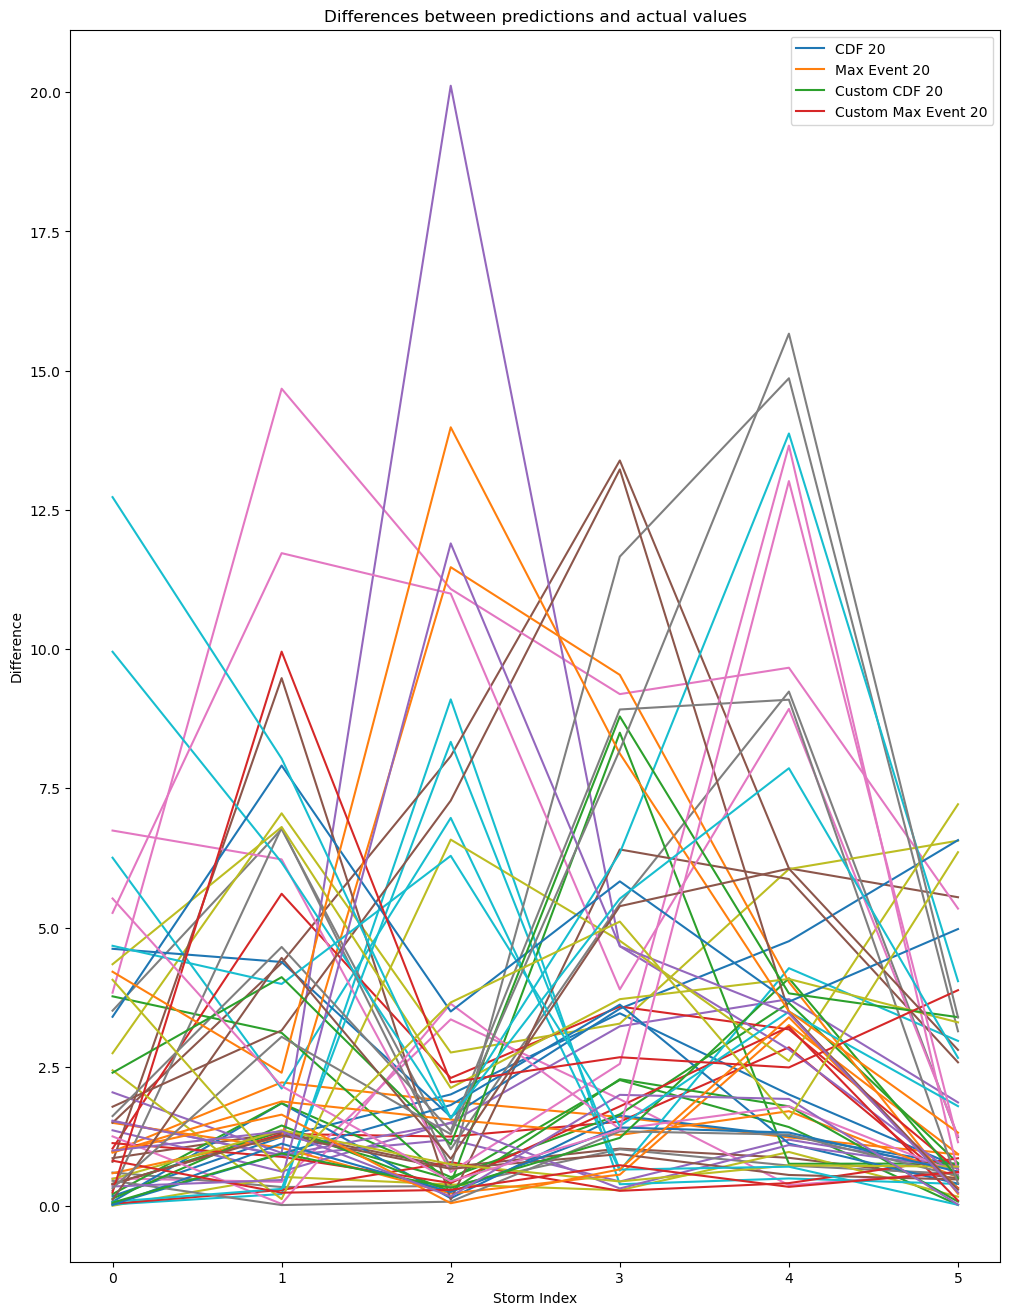

In [60]:
# calculate the difference from the predictions and the actual values
diff_cdf_20 = abs(predictions_xgb_cdf_20 - y_validation_cdf)
diff_max_20 = abs(predictions_xgb_max_20 - y_validation_max)

diff_cdf_30 = abs(predictions_xgb_cdf_30 - y_validation_cdf)
diff_max_30 = abs(predictions_xgb_max_30 - y_validation_max)

diff_cdf_40 = abs(predictions_xgb_cdf_40 - y_validation_cdf)
diff_max_40 = abs(predictions_xgb_max_40 - y_validation_max)

diff_custom_cdf_20 = abs(predictions_xgb_custom_cdf_20 - y_validation_cdf)
diff_custom_max_20 = abs(predictions_xgb_custom_max_20 - y_validation_max)

diff_custom_cdf_30 = abs(predictions_xgb_custom_cdf_30 - y_validation_cdf)
diff_custom_max_30 = abs(predictions_xgb_custom_max_30 - y_validation_max)

diff_custom_cdf_40 = abs(predictions_xgb_custom_cdf_40 - y_validation_cdf)
diff_custom_max_40 = abs(predictions_xgb_custom_max_40 - y_validation_max)

# calculate the mean of the differences per cluster

mean_diff_cdf_20 = np.mean(diff_cdf_20, axis=0)
mean_diff_max_20 = np.mean(diff_max_20, axis=0)

mean_diff_cdf_30 = np.mean(diff_cdf_30, axis=0)
mean_diff_max_30 = np.mean(diff_max_30, axis=0)

mean_diff_cdf_40 = np.mean(diff_cdf_40, axis=0)
mean_diff_max_40 = np.mean(diff_max_40, axis=0)

mean_diff_custom_cdf_20 = np.mean(diff_custom_cdf_20, axis=0)
mean_diff_custom_max_20 = np.mean(diff_custom_max_20, axis=0)

mean_diff_custom_cdf_30 = np.mean(diff_custom_cdf_30, axis=0)
mean_diff_custom_max_30 = np.mean(diff_custom_max_30, axis=0)

mean_diff_custom_cdf_40 = np.mean(diff_custom_cdf_40, axis=0)
mean_diff_custom_max_40 = np.mean(diff_custom_max_40, axis=0)

# transpose the data
'''mean_diff_cdf_20 = mean_diff_cdf_20.reshape(1, -1)
mean_diff_max_20 = mean_diff_max_20.reshape(1, -1)

mean_diff_cdf_30 = mean_diff_cdf_30.reshape(1, -1)
mean_diff_max_30 = mean_diff_max_30.reshape(1, -1)

mean_diff_cdf_40 = mean_diff_cdf_40.reshape(1, -1)
mean_diff_max_40 = mean_diff_max_40.reshape(1, -1)

mean_diff_custom_cdf_20 = mean_diff_custom_cdf_20.reshape(1, -1)
mean_diff_custom_max_20 = mean_diff_custom_max_20.reshape(1, -1)

mean_diff_custom_cdf_30 = mean_diff_custom_cdf_30.reshape(1, -1)
mean_diff_custom_max_30 = mean_diff_custom_max_30.reshape(1, -1)

mean_diff_custom_cdf_40 = mean_diff_custom_cdf_40.reshape(1, -1)
mean_diff_custom_max_40 = mean_diff_custom_max_40.reshape(1, -1)
'''
# save the differences to a csv file
pd.DataFrame(mean_diff_cdf_20).to_csv('pre_processing/feature_selection/differences_on_valid/diff_cdf_20.csv')
pd.DataFrame(mean_diff_max_20).to_csv('pre_processing/feature_selection/differences_on_valid/diff_max_20.csv')

pd.DataFrame(mean_diff_cdf_30).to_csv('pre_processing/feature_selection/differences_on_valid/diff_cdf_30.csv')
pd.DataFrame(mean_diff_max_30).to_csv('pre_processing/feature_selection/differences_on_valid/diff_max_30.csv')

pd.DataFrame(mean_diff_cdf_40).to_csv('pre_processing/feature_selection/differences_on_valid/diff_cdf_40.csv')
pd.DataFrame(mean_diff_max_40).to_csv('pre_processing/feature_selection/differences_on_valid/diff_max_40.csv')

pd.DataFrame(mean_diff_custom_cdf_20).to_csv('pre_processing/feature_selection/differences_on_valid/diff_custom_cdf_20.csv')
pd.DataFrame(mean_diff_custom_max_20).to_csv('pre_processing/feature_selection/differences_on_valid/diff_custom_max_20.csv')

pd.DataFrame(mean_diff_custom_cdf_30).to_csv('pre_processing/feature_selection/differences_on_valid/diff_custom_cdf_30.csv')
pd.DataFrame(mean_diff_custom_max_30).to_csv('pre_processing/feature_selection/differences_on_valid/diff_custom_max_30.csv')

pd.DataFrame(mean_diff_custom_cdf_40).to_csv('pre_processing/feature_selection/differences_on_valid/diff_custom_cdf_40.csv')
pd.DataFrame(mean_diff_custom_max_40).to_csv('pre_processing/feature_selection/differences_on_valid/diff_custom_max_40.csv')

# plot the differences
plt.figure(figsize=(12, 16))
plt.plot(diff_cdf_20)
plt.plot(diff_max_20)
plt.plot(diff_custom_cdf_20)
plt.plot(diff_custom_max_20)
plt.xlabel('Storm Index')
plt.ylabel('Difference')
plt.title('Differences between predictions and actual values')
plt.legend(['CDF 20', 'Max Event 20', 'Custom CDF 20', 'Custom Max Event 20'])
plt.show()


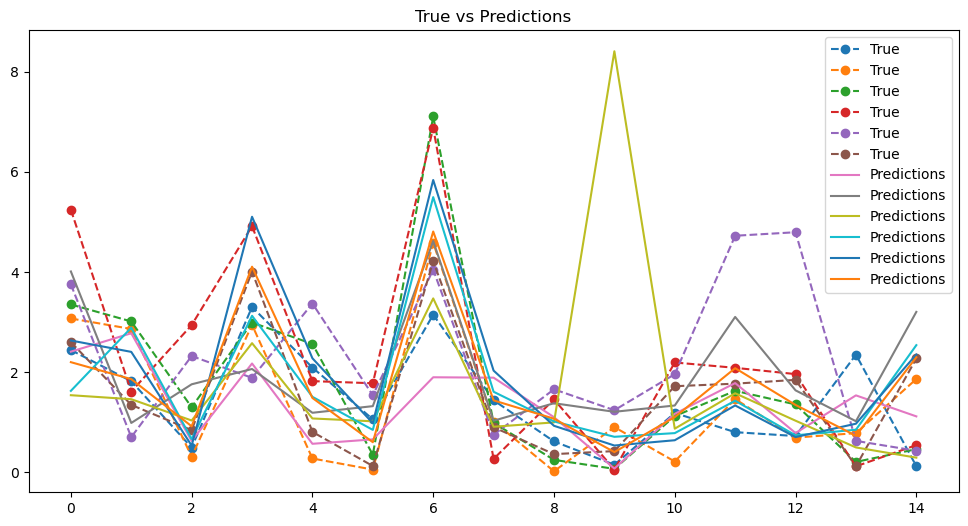

In [42]:
# plot the y_true and the predictions
cluster_n = 9
# plot the y_true and the predictions
plt.figure(figsize=(12, 6))
plt.plot(y_validation_cdf.T[:], label = 'True', linestyle='dashed',marker="o")
plt.plot(predictions_xgb_custom_cdf_20.T[:], label='Predictions')
plt.title('True vs Predictions')
plt.legend()
plt.show()
